In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob, Word
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [73]:
data = pd.read_csv('consumer_complaints.csv')
data.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [74]:
data.columns.values

array(['date_received', 'product', 'sub_product', 'issue', 'sub_issue',
       'consumer_complaint_narrative', 'company_public_response',
       'company', 'state', 'zipcode', 'tags', 'consumer_consent_provided',
       'submitted_via', 'date_sent_to_company',
       'company_response_to_consumer', 'timely_response',
       'consumer_disputed?', 'complaint_id'], dtype=object)

In [3]:
data = data[['product', 'issue']]
data.head()

,product,issue
0,Mortgage,"Loan modification,collection,foreclosure"
1,Mortgage,"Loan servicing, payments, escrow account"
2,Credit reporting,Incorrect information on credit report
3,Student loan,Repaying your loan
4,Debt collection,False statements or representation


***Text Cleaning***

In [4]:
# lower casing, Punctuation, stopwords removing, stemming and lemmitization
import re
stop = stopwords.words('english')
st = SnowballStemmer(language='english')

data['issue'] = data['issue'].apply(lambda x: ' '.join(x.lower() for x in x.split()))
data['issue'] = data['issue'].apply(lambda x: re.sub('[^\w\s]', '', x))
data['issue'] = data['issue'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop))
data['issue'] = data['issue'].apply(lambda x: ' '.join(st.stem(word) for word in x.split()))
data['issue'] = data['issue'].apply(lambda x: ' '.join(Word(word).lemmatize() for word in x.split()))

In [5]:
data.head()

,product,issue
0,Mortgage,loan modificationcollectionforeclosur
1,Mortgage,loan servic payment escrow account
2,Credit reporting,incorrect inform credit report
3,Student loan,repay loan
4,Debt collection,fals statement represent


In [6]:
data['product_id'], uniques = data['product'].factorize()
data.head()

,product,issue,product_id
0,Mortgage,loan modificationcollectionforeclosur,0
1,Mortgage,loan servic payment escrow account,0
2,Credit reporting,incorrect inform credit report,1
3,Student loan,repay loan,2
4,Debt collection,fals statement represent,3


In [7]:
data.groupby('product').issue.count()

product
Bank account or service     62563
Consumer Loan               20990
Credit card                 66468
Credit reporting            91854
Debt collection            101052
Money transfers              3812
Mortgage                   186475
Other financial service       557
Payday loan                  3877
Prepaid card                 2470
Student loan                15839
Name: issue, dtype: int64

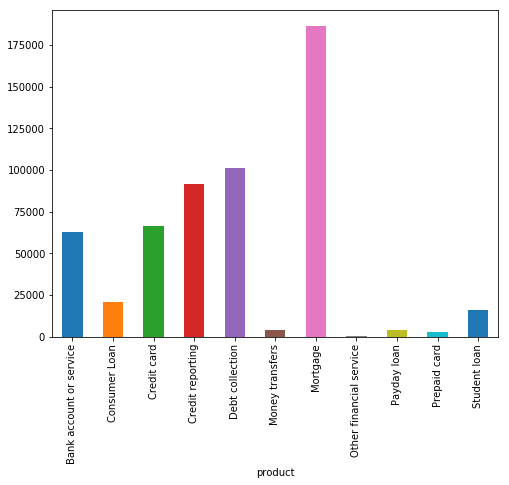

In [8]:
fig = plt.figure(figsize=(8,6))
data.groupby('product').issue.count().plot.bar(ylim= 0)
plt.show()

In [9]:
data.isna().sum()

product       0
issue         0
product_id    0
dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 3 columns):
product       555957 non-null object
issue         555957 non-null object
product_id    555957 non-null int64
dtypes: int64(1), object(2)
memory usage: 12.7+ MB


In [11]:
uniques

Index(['Mortgage', 'Credit reporting', 'Student loan', 'Debt collection',
       'Credit card', 'Bank account or service', 'Consumer Loan',
       'Money transfers', 'Payday loan', 'Prepaid card',
       'Other financial service'],
      dtype='object')

In [12]:
X = data['issue']
y = data['product_id']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.25)

In [14]:
tfidf = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)

In [15]:
x_train = tfidf.fit_transform(X_train)
x_train.shape

(416967, 150)

In [16]:
x_test = tfidf.transform(X_test)
x_test.shape

(138990, 150)

***Logistic Regression***

In [17]:
lg = LogisticRegression()
lg.fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [18]:
lg_pred = lg.predict(x_test)

In [19]:
lg_pred

array([5, 0, 0, ..., 3, 3, 2], dtype=int64)

In [38]:
lg_acc = accuracy_score(lg_pred, y_test)

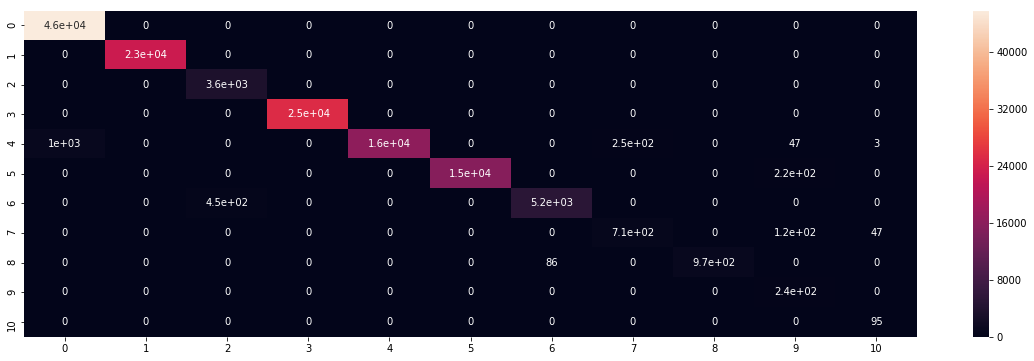

In [25]:
import seaborn as sns
cm = confusion_matrix(lg_pred, y_test)
fig = plt.figure(figsize=(20, 6))
sns.heatmap(cm, annot=True)

In [39]:
lg_acc

0.9837182531117347

***Navie Bayies***

In [26]:
nb = MultinomialNB(alpha=0.2)
nb.fit(x_train, y_train)

MultinomialNB(alpha=0.2, class_prior=None, fit_prior=True)

In [27]:
nb_pred = nb.predict(x_test)
nb_pred

array([5, 0, 0, ..., 3, 3, 2], dtype=int64)

In [37]:
nb_acc = accuracy_score(nb_pred, y_test)

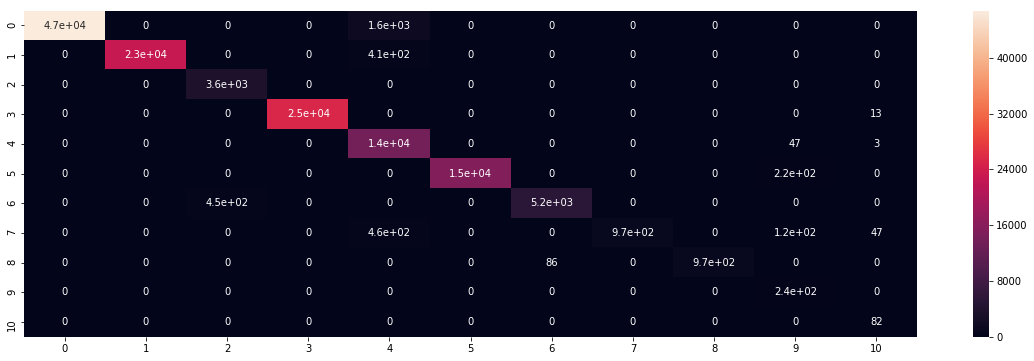

In [40]:
import seaborn as sns
cm = confusion_matrix(nb_pred, y_test)
fig = plt.figure(figsize=(20, 6))
sns.heatmap(cm, annot=True)

In [41]:
nb_acc

0.9750125908338729

***SVM***

In [29]:
svm =SVC()
svm.fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [30]:
svm_pred = svm.predict(x_test)
svm_pred

array([5, 0, 0, ..., 3, 3, 2], dtype=int64)

In [36]:
svm_acc = accuracy_score(svm_pred, y_test)

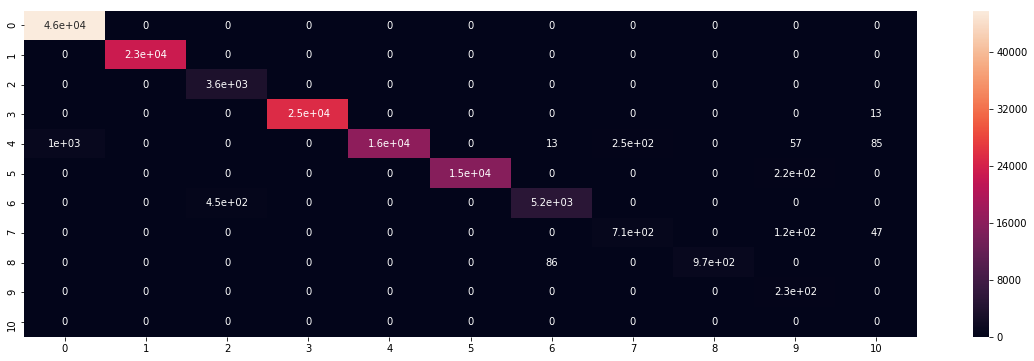

In [42]:
import seaborn as sns
cm = confusion_matrix(svm_pred, y_test)
fig = plt.figure(figsize=(20, 6))
sns.heatmap(cm, annot=True)

In [43]:
svm_acc

0.9828692711705879

***Random Forest Classifier***

In [32]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [33]:
rf_pred = rf.predict(x_test)
rf_pred

array([5, 0, 0, ..., 3, 3, 2], dtype=int64)

In [35]:
rf_acc = accuracy_score(rf_pred, y_test)

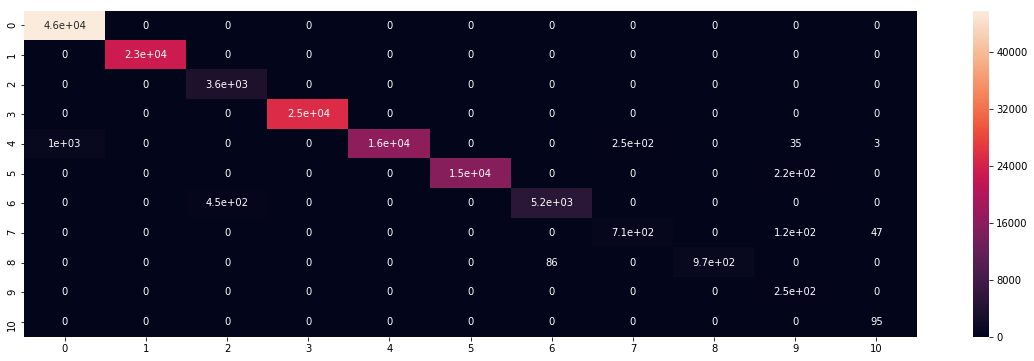

In [44]:
import seaborn as sns
cm = confusion_matrix(rf_pred, y_test)
fig = plt.figure(figsize=(20, 6))
sns.heatmap(cm, annot=True)

In [45]:
rf_acc

0.9838045902582919

***XGB Classifier***

In [49]:
import xgboost
from xgboost.sklearn import XGBClassifier

In [56]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [57]:
xgb_pred = xgb.predict(x_test)

In [58]:
xgb_acc = accuracy_score(xgb_pred, y_test)

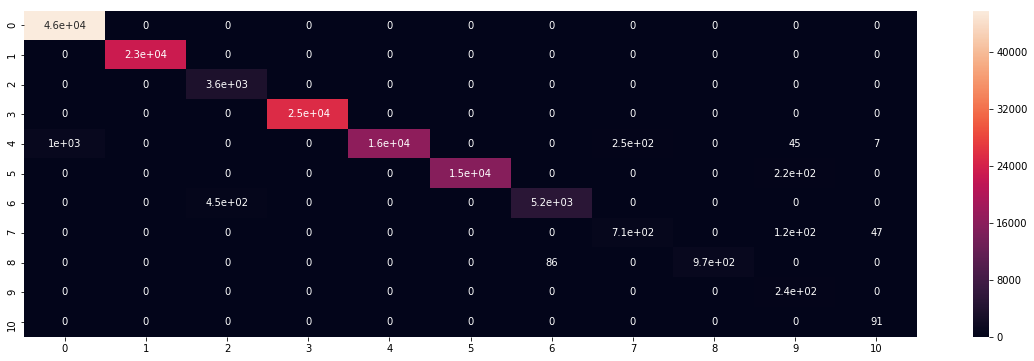

In [59]:
import seaborn as sns
cm = confusion_matrix(xgb_pred, y_test)
fig = plt.figure(figsize=(20, 6))
sns.heatmap(cm, annot=True)

In [60]:
xgb_acc

0.9837038635873084

In [71]:
max_ = max(lg_acc, nb_acc, svm_acc, rf_acc, xgb_acc)
if max_ == lg_acc: 
    print('logistic regression has highest accuracy of {0:.2f} % among others'.format(max_ * 100))
elif (max_ == nb_acc):
    print('Navie Bayes has highest accuracy of {0:.2f} % among others'.format(max_ * 100))
elif (max_ == svm_acc):
    print('Support Vector Classifier has highest accuracy of {0:.2f} % among others'.format(max_ * 100))
elif (max_ == rf_acc):
    print('Random Forest Classifier has highest accuracy of {0:.2f} % among others'.format(max_ * 100))
else:
    print('XG Boost Classifier has highest accuracy of {0:.2f} % among others'.format(max_ * 100))

Random Forest Classifier has highest accuracy of 98.38 % among others
